# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

### Общее описание данных

In [681]:
import pandas as pd
import seaborn as sns
from scipy import stats as st

import matplotlib.pyplot as plt
%matplotlib inline

In [682]:
try:
    data = pd.read_csv('/datasets/games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

In [683]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


In [684]:
#Заменяем названия столбцов (приводим к нижнему регистру);
data.columns = data.columns.str.lower()

In [685]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Описание данных
* `name` — название игры
* `platform` — платформа
* `year_of_release` — год выпуска
* `genre` — жанр игры
* `na_sales` — продажи в Северной Америке (миллионы проданных копий)
* `eu_sales` — продажи в Европе (миллионы проданных копий)
* `jp_sales` — продажи в Японии (миллионы проданных копий)
* `other_sales` — продажи в других странах (миллионы проданных копий)
* `critic_score` — оценка критиков (максимум 100)
* `user_score` — оценка пользователей (максимум 10)
* `rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

Видим, что есть столбцы с неоптимальным типом данных: `year_of_release`, `user_score`, `critic_score`. А также видим, что есть пропуски в некоторых столбцах. Далее будем работать над устранением проблемм с выборкой.

### Предобработка данных

#### Поиск и обработка пропусков

Проверим данные на наличие пропусков.

In [686]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         6701
rating             6766
dtype: int64

In [687]:
data.isna().sum()/len(data)

name               0.000120
platform           0.000000
year_of_release    0.016093
genre              0.000120
na_sales           0.000000
eu_sales           0.000000
jp_sales           0.000000
other_sales        0.000000
critic_score       0.513192
user_score         0.400897
rating             0.404786
dtype: float64

Видим, что большое кол-во пропусков в столбцах:
* critic_score — оценка критиков (максимум 100)
* user_score — оценка пользователей (максимум 10)
* rating — рейтинг от организации ESRB

In [688]:
data[data['name'].isna()==True]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Видим, что пропуски в столбцах name и genre у одних и тех же строк, поэтому просто избавимся от них.

In [689]:
data = data[data['genre'].isna()==False].reset_index()

Обработаем `year_of_release`

In [690]:
data[data['year_of_release'].isna()==True]['name'].value_counts()

LEGO Harry Potter: Years 5-7               7
Rock Band                                  4
Happy Feet Two                             4
Bejeweled 3                                3
WRC: FIA World Rally Championship          3
                                          ..
Dead Island: Riptide                       1
Shonen Jump's Yu-Gi-Oh! GX Card Almanac    1
Combat Wings: The Great Battles of WWII    1
Jonah Lomu Rugby Challenge                 1
WCW Backstage Assault                      1
Name: name, Length: 232, dtype: int64

In [691]:
data[data['year_of_release'].isna()==True]['name'].unique()

array(['Madden NFL 2004', 'FIFA Soccer 2004',
       'LEGO Batman: The Videogame', 'wwe Smackdown vs. Raw 2006',
       'Space Invaders', 'Rock Band',
       "Frogger's Adventures: Temple of the Frog",
       'LEGO Indiana Jones: The Original Adventures', 'Call of Duty 3',
       'Call of Duty: Black Ops', 'Triple Play 99', 'Adventure', 'Combat',
       'LEGO Harry Potter: Years 5-7', 'NASCAR Thunder 2003',
       'Hitman 2: Silent Assassin', 'Legacy of Kain: Soul Reaver',
       'Donkey Kong Land III', 'Air-Sea Battle', 'Suikoden III',
       'Wheel of Fortune', 'Yakuza 4', 'Namco Museum', 'Rhythm Heaven',
       'The Lord of the Rings: War in the North', 'Madden NFL 07',
       'MLB SlugFest 20-03', 'Shaun White Snowboarding',
       'PES 2009: Pro Evolution Soccer', 'WarioWare: Twisted!',
       'Madden NFL 11', 'Test Drive Unlimited 2',
       'The Chronicles of Narnia: The Lion, The Witch and The Wardrobe',
       'Monster Hunter 2', 'Metal Gear Solid 2: Substance',
       'Advanc

In [692]:
games_without_year_of_release = list(data[data['year_of_release'].isna()==True]['name'].unique())

In [693]:
data[(data['name'].isin(games_without_year_of_release)) & (data['year_of_release'].isna()==False)].\
groupby(['name','year_of_release'])['platform'].count()

name                                    year_of_release
AKB1/48: Idol to Guam de Koishitara...  2011.0             1
Aquaman: Battle for Atlantis            2003.0             1
Battle vs. Chess                        2011.0             1
Bejeweled 3                             2010.0             1
BioShock 2                              2010.0             2
                                                          ..
Wheel of Fortune                        1997.0             1
                                        1998.0             1
                                        2010.0             2
Without Warning                         2005.0             1
World of Tanks                          2011.0             1
Name: platform, Length: 113, dtype: int64

Часть пропусков в значениях `year_of_release` можно заполнить на основе данных о выходе конкретных игр, но на других платформах. Но поскольку пропусков небольшое кол-во и нет уверенности, что игры выходят на всех платформах в одно время, то мы просто избавимся от этих строк.

In [694]:
data = data[data['year_of_release'].isna()==False]

Проверим значения в `critic_score`

In [695]:
data['critic_score'].value_counts()

70.0    252
71.0    248
75.0    240
80.0    235
73.0    234
       ... 
29.0      3
20.0      3
13.0      1
17.0      1
21.0      1
Name: critic_score, Length: 81, dtype: int64

In [696]:
data['critic_score'].unique()

array([76., nan, 82., 80., 89., 58., 87., 91., 61., 97., 95., 77., 88.,
       83., 94., 93., 85., 86., 98., 96., 90., 84., 73., 74., 78., 92.,
       71., 72., 68., 62., 49., 67., 81., 66., 56., 79., 70., 59., 64.,
       75., 60., 63., 69., 50., 25., 42., 44., 55., 48., 57., 29., 47.,
       65., 54., 20., 53., 37., 38., 33., 52., 30., 32., 43., 45., 51.,
       40., 46., 39., 34., 41., 36., 31., 27., 35., 26., 19., 28., 23.,
       24., 21., 17., 13.])

Заполним пропуски в `critic_score`

In [697]:
data['critic_score'] = data['critic_score'].fillna(0)

Проверим значения в `user_score`

In [698]:
data['user_score'].value_counts()

tbd    2376
7.8     322
8       285
8.2     276
8.3     252
       ... 
1.9       2
2.3       2
1         2
9.7       1
0         1
Name: user_score, Length: 96, dtype: int64

In [699]:
data[data['user_score']=='tbd']

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,119,Zumba Fitness,Wii,2010.0,Sports,3.45,2.59,0.0,0.66,0.0,tbd,E
301,301,Namco Museum: 50th Anniversary,PS2,2005.0,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,520,Zumba Fitness 2,Wii,2011.0,Sports,1.51,1.03,0.0,0.27,0.0,tbd,T
645,645,uDraw Studio,Wii,2010.0,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
717,718,Just Dance Kids,Wii,2010.0,Misc,1.52,0.54,0.0,0.18,0.0,tbd,E
...,...,...,...,...,...,...,...,...,...,...,...,...
16693,16695,Planet Monsters,GBA,2001.0,Action,0.01,0.00,0.0,0.00,67.0,tbd,E
16695,16697,Bust-A-Move 3000,GC,2003.0,Puzzle,0.01,0.00,0.0,0.00,53.0,tbd,E
16696,16698,Mega Brain Boost,DS,2008.0,Puzzle,0.01,0.00,0.0,0.00,48.0,tbd,E
16702,16704,Plushees,DS,2008.0,Simulation,0.01,0.00,0.0,0.00,0.0,tbd,E


In [700]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Заполним явные и неявные пропуски в `user_score`

In [701]:
data['user_score'] = data['user_score'].fillna(-1)
data.loc[(data['user_score']=='tbd'), ('user_score')] = -1

Проверим значения в `rating`

In [702]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Заполним пропуски в `rating`

In [703]:
data['rating'] = data['rating'].fillna('No_Rating')

Ещё раз проверим на наличие пропусков в данных.

In [704]:
data.isna().sum()

index              0
name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

#### Типы данных

In [705]:
#изменяем тип данных
data[['year_of_release','critic_score']] = data[['year_of_release','critic_score']].astype(int)
data[['user_score']] = data[['user_score']].astype('float32')

#### Проверка на явные и неявные дубликаты

Для начала проверим выборку на полные дубликаты.

In [706]:
data.duplicated().sum()

0

Рассмотрим, нет ли неявных дубликатов в категориальных данных.

In [707]:
data['platform'].unique()

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

In [708]:
data['genre'].unique()

array(['Sports', 'Platform', 'Racing', 'Role-Playing', 'Puzzle', 'Misc',
       'Shooter', 'Simulation', 'Action', 'Fighting', 'Adventure',
       'Strategy'], dtype=object)

In [709]:
data.duplicated(['name','platform']).sum()

3

In [710]:
data[data.duplicated(['name','platform'])==True]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1590,1591,Need for Speed: Most Wanted,X360,2005,Racing,1.0,0.13,0.02,0.10,83,8.5,T
11714,11715,Need for Speed: Most Wanted,PC,2012,Racing,0.0,0.06,0.00,0.02,82,8.5,T
16228,16230,Madden NFL 13,PS3,2012,Sports,0.0,0.01,0.00,0.00,83,5.5,E


In [711]:
data[(data['name']=='Need for Speed: Most Wanted') & (data['platform']=='X360')]

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
1189,1190,Need for Speed: Most Wanted,X360,2012,Racing,0.62,0.78,0.01,0.15,83,8.5,T
1590,1591,Need for Speed: Most Wanted,X360,2005,Racing,1.00,0.13,0.02,0.10,83,8.5,T


Видим, что есть три строки, с неявными дублями. Возможно в этих строках есть ошибки. Но поскольку таких строк мало, и они не окажут влияние на дальнейший анализ, то оставим их в таком виде, как есть.

Как видим, полных дублей в нашей выборке нет. Идём далее.

###  Суммарные продажи во всех регионах

In [712]:
data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,-1.0,No_Rating
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,-1.0,No_Rating


Добавим столбец с сумарными продажами по всем регионам.

In [713]:
data['total_sales'] = data.loc[:,['na_sales', 'eu_sales', 'eu_sales', 'jp_sales', 'other_sales']].sum(axis=1)

In [714]:
data.head()

,index,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76,8.0,E,111.50
1,1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,0,-1.0,No_Rating,43.82
2,2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82,8.3,E,48.28
3,3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80,8.0,E,43.70
4,4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,0,-1.0,No_Rating,40.27


###  Исследовательский анализ данных

#### Сколько игр выпускалось в разные годы. Важны ли данные за все периоды?

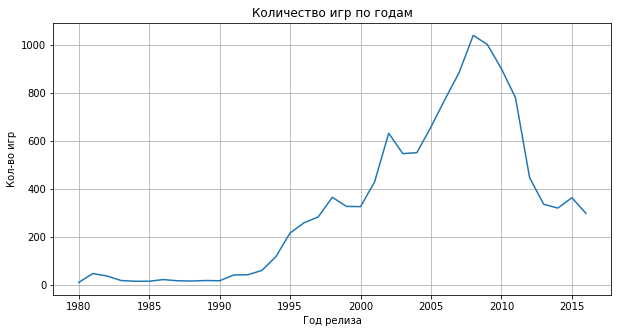

In [715]:
data[(data[['name','year_of_release']].duplicated()==False) & (data['year_of_release']>0)][['name','year_of_release']].\
groupby('year_of_release').count().\
plot(grid=True, figsize=(10, 5), legend=False, title='Количество игр по годам').\
set(xlabel='Год релиза', ylabel='Кол-во игр');

Количество выпускаемых игр начало расти с начала 90-х. Насыщение по кол-ву выпускаемых игр наступило в 2007 году, и затем началось снижение. Можно смело не учитывать данные до 1990 года.

#### Как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?

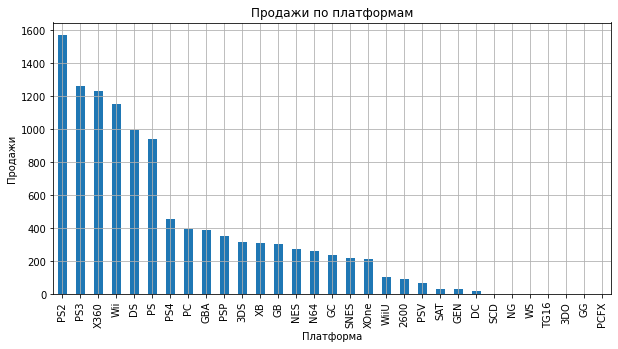

In [716]:
data.pivot_table(index='platform',values='total_sales',aggfunc='sum').\
sort_values('total_sales', ascending=False).\
plot(grid=True, kind='bar', figsize=(10, 5), legend=False, title='Продажи по платформам').\
set(xlabel='Платформа', ylabel='Продажи');

Исходя из графика видно, что явных лидеров 6, но мы далее будем анализировать топ 10.

In [717]:
top_platform = data.pivot_table(index='platform',values='total_sales',aggfunc='sum').\
sort_values('total_sales', ascending=False).head(10)
top_platform

,total_sales
platform,
PS2,1566.19
PS3,1258.55
X360,1229.56
Wii,1149.50
DS,991.19
PS,939.97
PS4,455.23
PC,396.13
GBA,387.47


In [718]:
list(top_platform.index)

['PS2', 'PS3', 'X360', 'Wii', 'DS', 'PS', 'PS4', 'PC', 'GBA', 'PSP']

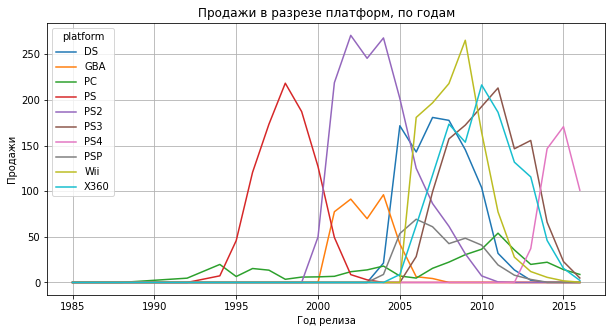

In [719]:
data.query('platform in list(@top_platform.index) and year_of_release>0').\
pivot_table(index='year_of_release',values='total_sales',columns='platform',aggfunc='sum').fillna(0).\
plot(grid=True, figsize=(10, 5), title='Продажи в разрезе платформ, по годам').\
set(xlabel='Год релиза', ylabel='Продажи');

Проанализировав график,  можно сделать выводы:
* Каждые 5-7 лет появляются новые платформы для игр.
* Платформа "живёт" около 10 лет.

#### Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.

Для дальнейшего анализа возьмём актуальные данные. Исходя из того, что мы проанализировали ранее, будем рассматривать данные начиная с 2014 года.

In [720]:
data_actual = data.query('2014<=year_of_release<2016')
#*данные за 2016 год не полные

In [721]:
data_actual.shape

(1187, 13)

In [722]:
top_platform_actual = data_actual.pivot_table(index='platform',values='total_sales',aggfunc='sum').\
sort_values('total_sales', ascending=False).head(10)
top_platform_actual

,total_sales
platform,
PS4,317.16
XOne,150.83
PS3,88.86
3DS,85.33
X360,61.48
WiiU,50.05
PC,36.24
PSV,21.29
Wii,7.37


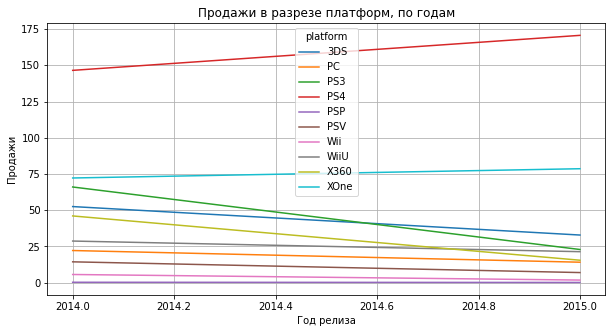

In [723]:
data_actual.query('platform in list(@top_platform_actual.index)').\
pivot_table(index='year_of_release',values='total_sales',columns='platform',aggfunc='sum').fillna(0).\
plot(grid=True, figsize=(10, 5), title='Продажи в разрезе платформ, по годам').\
set(xlabel='Год релиза', ylabel='Продажи');

Растущими, и наиболее перспективными являются две платформы: PS4 и XOne. Данные платформы пришли на смену своих предшественников PS3 и X360.

#### График «ящик с усами» по глобальным продажам игр в разбивке по платформам.

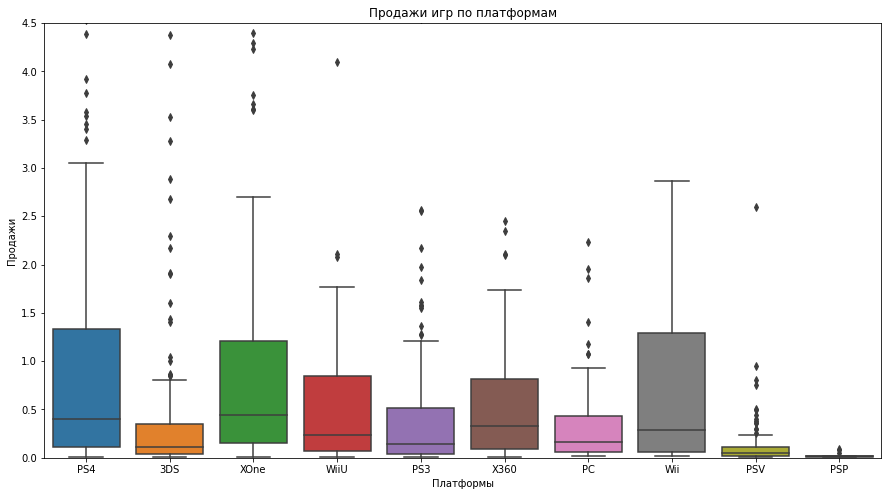

In [724]:
plt.figure(figsize=(15, 8))
plt.ylim(0, 4.5)
sns.boxplot(data=data_actual, x='platform', y='total_sales').\
set(xlabel='Платформы', ylabel='Продажи', title='Продажи игр по платформам')
plt.show()

Видим, что у платформ PS4 и XOne более высокие медианные значения. Также близко находятся платформы Wii и X360.

#### Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.

Для анализа возьмём данные по двум самым популярным платформам за выбранный период (PS3, X360) и по двум набирающим популярность в рассматриваемый период платформам (PS4 и XOne)

In [725]:
data_actual.query('platform=="PS4" and user_score>=0 and critic_score>0')[['critic_score','user_score','total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.602514,0.409803
user_score,0.602514,1.000000,-0.016003
total_sales,0.409803,-0.016003,1.000000


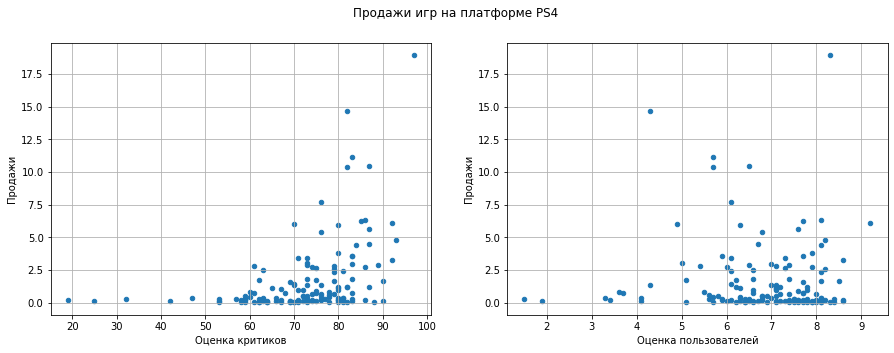

In [726]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

fig.suptitle('Продажи игр на платформе PS4')

data_actual.query('platform=="PS4" and user_score>=0 and critic_score>0').\
plot(x='critic_score', y='total_sales', kind='scatter',grid=True, ax=axes[0]).\
set(xlabel='Оценка критиков', ylabel='Продажи')

data_actual.query('platform=="PS4" and user_score>=0 and critic_score>0').\
plot(x='user_score', y='total_sales', kind='scatter',grid=True, ax=axes[1]).\
set(xlabel='Оценка пользователей', ylabel='Продажи')

plt.show()

In [727]:
data_actual.query('platform=="PS3" and user_score>=0 and critic_score>0')[['critic_score','user_score','total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.693445,0.406851
user_score,0.693445,1.000000,0.113568
total_sales,0.406851,0.113568,1.000000


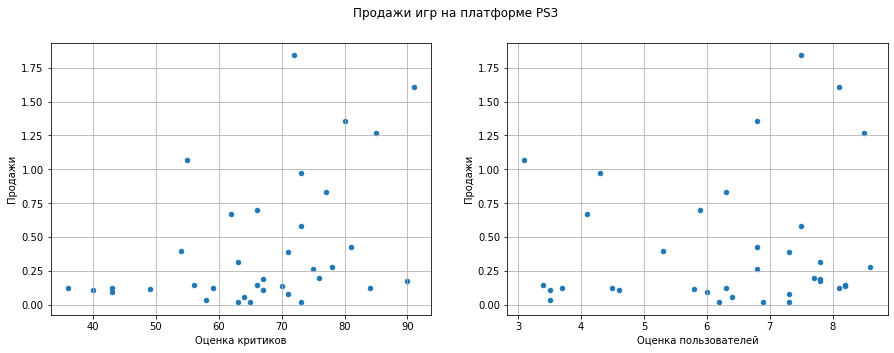

In [728]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

fig.suptitle('Продажи игр на платформе PS3')

data_actual.query('platform=="PS3" and user_score>=0 and critic_score>0 and total_sales<=5').\
plot(x='critic_score', y='total_sales', kind='scatter', grid=True, ax=axes[0]).\
set(xlabel='Оценка критиков', ylabel='Продажи')

data_actual.query('platform=="PS3" and user_score>=0 and critic_score>0 and total_sales<=5').\
plot(x='user_score', y='total_sales', kind='scatter', grid=True, ax=axes[1]).\
set(xlabel='Оценка пользователей', ylabel='Продажи')

plt.show()

In [729]:
data_actual.query('platform=="X360" and user_score>=0 and critic_score>0')[['critic_score','user_score','total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.625309,0.511123
user_score,0.625309,1.000000,0.334478
total_sales,0.511123,0.334478,1.000000


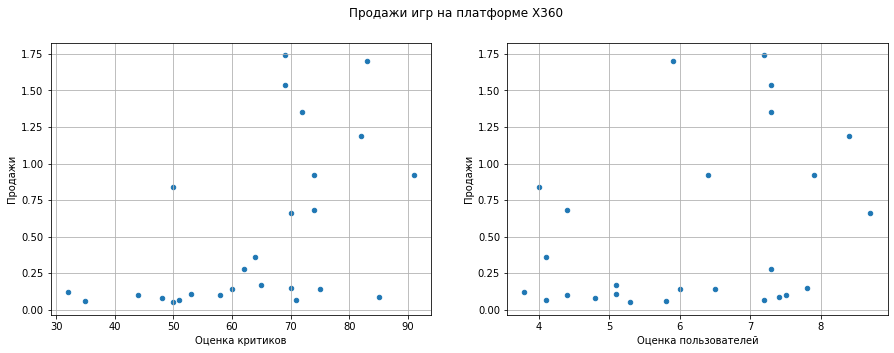

In [730]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

fig.suptitle('Продажи игр на платформе X360')

data_actual.query('platform=="X360" and user_score>=0 and critic_score>0  and total_sales<=5').\
plot(x='critic_score', y='total_sales', kind='scatter', grid=True, ax=axes[0]).\
set(xlabel='Оценка критиков', ylabel='Продажи')

data_actual.query('platform=="X360" and user_score>=0 and critic_score>0  and total_sales<=5').\
plot(x='user_score', y='total_sales', kind='scatter', grid=True, ax=axes[1]).\
set(xlabel='Оценка пользователей', ylabel='Продажи')

plt.show()

In [731]:
data_actual.query('platform=="XOne" and user_score>=0 and critic_score>0')[['critic_score','user_score','total_sales']].corr()

,critic_score,user_score,total_sales
critic_score,1.000000,0.453434,0.468115
user_score,0.453434,1.000000,-0.059719
total_sales,0.468115,-0.059719,1.000000


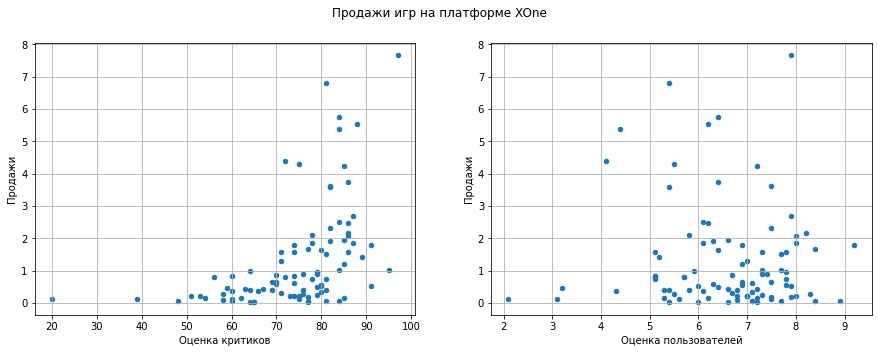

In [732]:
fig, axes = plt.subplots(ncols=2, figsize=(15, 5))

fig.suptitle('Продажи игр на платформе XOne')

data_actual.query('platform=="XOne" and user_score>=0 and critic_score>0').\
plot(x='critic_score', y='total_sales', kind='scatter',grid=True, ax=axes[0]).\
set(xlabel='Оценка критиков', ylabel='Продажи')

data_actual.query('platform=="XOne" and user_score>=0 and critic_score>0').\
plot(x='user_score', y='total_sales', kind='scatter',grid=True, ax=axes[1]).\
set(xlabel='Оценка пользователей', ylabel='Продажи')

plt.show()

Исходя из полученных коэффициентов корреляции и диаграмм рассеивания приходим к следующим выводам:
    
* взаимосвязь между отзывами пользователей и продажами отсутствует для всех рассмотренных платформ;
* взаимосвязь между отзывами критиков и продажами существует, она положительная,но не слишком большая (для каких-то платформ чуть больше, для каких-то чуть меньше, но не существенно);

#### Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

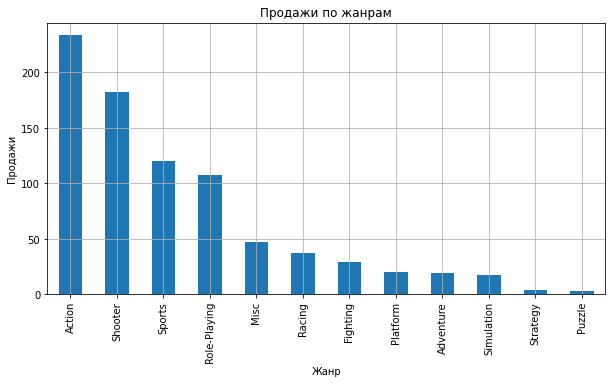

In [733]:
data_actual.pivot_table(index='genre',values='total_sales',aggfunc='sum').\
sort_values('total_sales', ascending=False).\
plot(grid=True, kind='bar', figsize=(10, 5), legend=False, title='Продажи по жанрам').\
set(xlabel='Жанр', ylabel='Продажи');

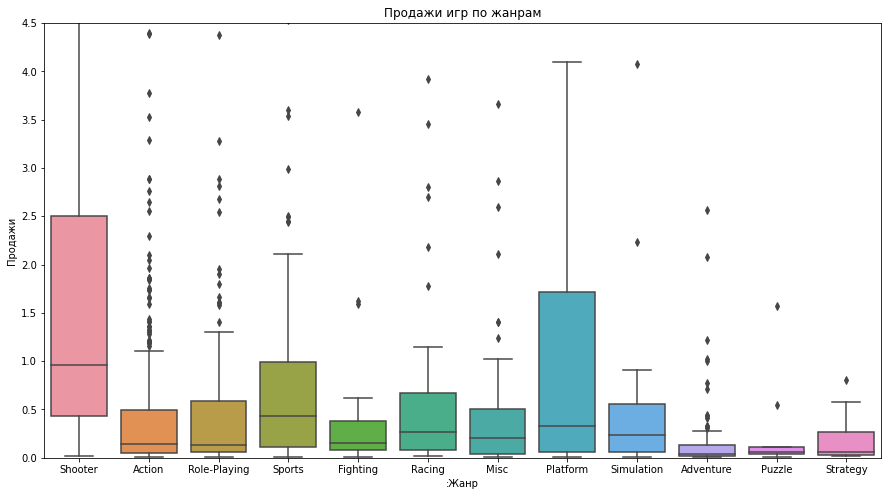

In [734]:
plt.figure(figsize=(15, 8))
plt.ylim(0, 4.5)
sns.boxplot(data=data_actual, x='genre', y='total_sales').\
set(xlabel=':Жанр', ylabel='Продажи', title='Продажи игр по жанрам')
plt.show()

Жанры с наибольшими общими продажами: Action (явный лидер), Shooter, Sports, Role-Playing.
Жанры с наименьшими общими продажами: Puzzle, Strategy.

Так же исходя из медианных показателей по продажам, видим, что наиболее привлекательный жанр игр это Shooter поскольку в этом жанре чаще всего игры приносят высокий доход.
При этом в жанре Action есть несколько игр, за счёт которых общие продажи этого жанра максимальные.

Чтобы говорить о прибыльности, нужно знать о затратах на производство и поддержку игр. В данном случае, мы можем говорить лишь о продажах и доходах.

### Портреты пользователей по регионам

Определим для пользователей каждого региона (NA, EU, JP):

* Самые популярные платформы (топ-5). Опишите различия в долях продаж.
* Самые популярные жанры (топ-5). Поясните разницу.
* Влияет ли рейтинг ESRB на продажи в отдельном регионе?

#### Самые популярные платформы

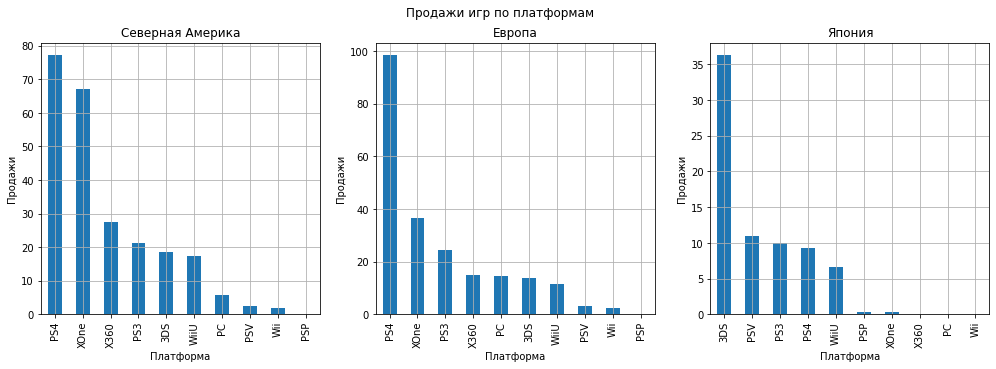

In [735]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 5))

fig.suptitle('Продажи игр по платформам')

data_actual.pivot_table(index='platform',values='na_sales',aggfunc='sum').\
sort_values('na_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Северная Америка',ax=axes[0]).\
set(xlabel='Платформа', ylabel='Продажи')

data_actual.pivot_table(index='platform',values='eu_sales',aggfunc='sum').\
sort_values('eu_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Европа',ax=axes[1]).\
set(xlabel='Платформа', ylabel='Продажи')

data_actual.pivot_table(index='platform',values='jp_sales',aggfunc='sum').\
sort_values('jp_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Япония',ax=axes[2]).\
set(xlabel='Платформа', ylabel='Продажи')

plt.show()

Видим, что в разных регионах, разное распределение продаж по платформам.

* В Северной Америке два лидера среди платформ это `PS4` и `XOne`
* В Европе явным лидером среди платформ является `PS4`
* В Японии явным лидером является платформа `3DS`

#### Самые популярные жанры

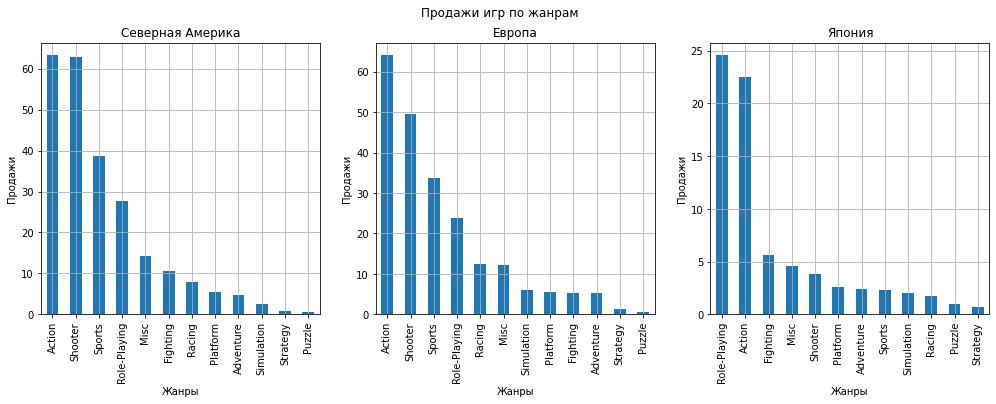

In [736]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 5))

fig.suptitle('Продажи игр по жанрам')

data_actual.pivot_table(index='genre',values='na_sales',aggfunc='sum').\
sort_values('na_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Северная Америка',ax=axes[0]).\
set(xlabel='Жанры', ylabel='Продажи')

data_actual.pivot_table(index='genre',values='eu_sales',aggfunc='sum').\
sort_values('eu_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Европа',ax=axes[1]).\
set(xlabel='Жанры', ylabel='Продажи')

data_actual.pivot_table(index='genre',values='jp_sales',aggfunc='sum').\
sort_values('jp_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Япония',ax=axes[2]).\
set(xlabel='Жанры', ylabel='Продажи')

plt.show()

Видим, что в Северной Америке и в Европе схожие предпочтения по жанрам, в отличии от Японии.

* В Северной Америке и в Европе явный лидер среди жанров это `Action`
* В Японии явным лидером является жанр `Role-Playing`

#### Влияние рейтинга ESRB на продажи по регионам

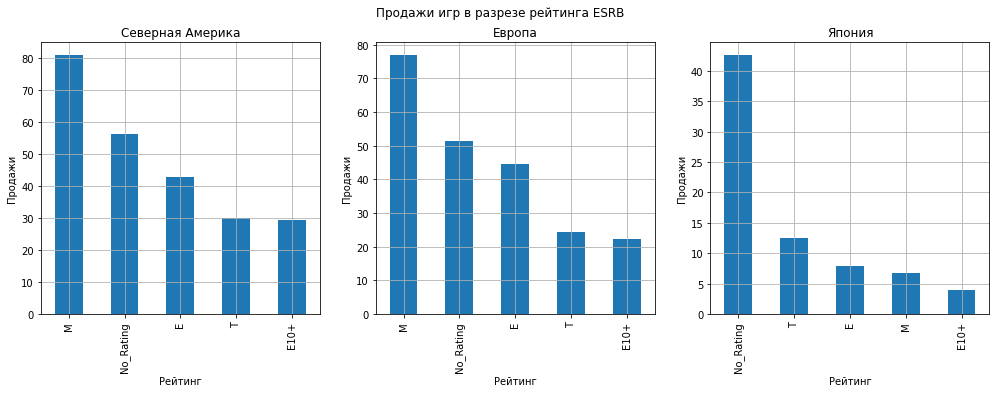

In [737]:
fig, axes = plt.subplots(ncols=3, figsize=(17, 5))

fig.suptitle('Продажи игр в разрезе рейтинга ESRB')

data_actual.pivot_table(index='rating',values='na_sales',aggfunc='sum').\
sort_values('na_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Северная Америка',ax=axes[0]).\
set(xlabel='Рейтинг', ylabel='Продажи')

data_actual.pivot_table(index='rating',values='eu_sales',aggfunc='sum').\
sort_values('eu_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Европа',ax=axes[1]).\
set(xlabel='Рейтинг', ylabel='Продажи')

data_actual.pivot_table(index='rating',values='jp_sales',aggfunc='sum').\
sort_values('jp_sales', ascending=False).\
plot(grid=True, kind='bar', legend=False, title='Япония',ax=axes[2]).\
set(xlabel='Рейтинг', ylabel='Продажи')

plt.show()

Видим, что по аналогии с игровыми жанрами, в Северной Америке и в Европе схожие распределения продаж в зависимости от возрастного реутинга, в отличии от Японии.

* В Северной Америке и в Европе явный лидером является группа `M`, на втором месте игры без рейтинга.
* В Японии лидером является группа `T`, но при этом больше всего игр остались без рейтинга.

### Проверка гипотез

#### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

Воспользуемся специальным методом для проверки гипотезы о равенстве среднего двух генеральных совокупностей по взятым из них выборкам.

```
H_0: Средние пользовательские рейтинги (user_score) игр на платформе "Xbox One" и на "PC" равны.
H_1: Средние пользовательские рейтинги (user_score) игр на платформе "Xbox One" и на "PC" не равны.
    
alpha = 0.05
```

In [738]:
xbox_user_rating = data_actual[(data_actual['platform'] =='XOne') & (data_actual['user_score']>=0.0)]['user_score']
pc_user_rating = data_actual[(data_actual['platform'] =='PC') & (data_actual['user_score']>=0.0)]['user_score']

In [739]:
print(xbox_user_rating.mean(), pc_user_rating.mean())

6.5919194 6.2987013


In [740]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(xbox_user_rating, pc_user_rating, equal_var=False)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу') 

0.20641464237821372
Не получилось отвергнуть нулевую гипотезу


Мы видим большое значение p-value, что говорит о том, что наша гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые подтвердилась.

#### Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные

```
H_0: Средние пользовательские рейтинги (user_score)  жанров "Action" и "Sports" равны.
H_1: Средние пользовательские рейтинги (user_score)  жанров "Action" и "Sports" не равны.
    
alpha = 0.05
```

In [741]:
action_user_rating = data_actual[(data_actual['genre'] =='Action') & (data_actual['user_score']>=0.0)]['user_score']
sports_user_rating = data_actual[(data_actual['genre'] =='Sports') & (data_actual['user_score']>=0.0)]['user_score']

In [742]:
print(action_user_rating.mean(), sports_user_rating.mean())

6.8094335 5.14


In [743]:
# results = вызов метода для проверки гипотезы
results = st.ttest_ind(action_user_rating, sports_user_rating, equal_var=False)
# alpha = задайте значение уровня значимости
alpha = 0.05
# вывод значения p-value на экран
print(results.pvalue)
# условный оператор с выводом строки с ответом
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

5.639224861385725e-13
Отвергаем нулевую гипотезу


Мы видим очень маленькое значение p-value, что говорит о том, что наша гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые не подтвердилась.

### Общий Вывод

Изучив исторические данные о продажах игр, мы пришли к следующим выводам:

* Продажи игр начали активно расти с начала 90-х годов. Насыщение рынка наступило в 2007 году, и затем началось снижение продаж.

* Примерно каждые 5-7 лет появляются новые платформы для игр, и новая латформа "живёт" около 10 лет.

* На 2016 год растущими, и наиболее перспективными являются две платформы: PS4 и XOne. Данные платформы пришли на смену своих предшественников PS3 и X360.
* Отсутствует взаимосвязь между отзывами пользователей и продажами. С другой стороны, взаимосвязь между отзывами критиков и продажами существует, она положительная, но не слишком большая (для каких-то платформ чуть больше, для каких-то чуть меньше, но не существенно).
* Жанры с наибольшими общими продажами: Action (явный лидер), Shooter, Sports, Role-Playing. Жанры с наименьшими продажами: Puzzle, Strategy.
* Исходя из медианных показателей по продажам, выяснили, что наиболее привлекательный с точки зрения бизнеса жанр игр это Shooter поскольку в этом жанре чаще всего игры приносят высокий доход. При этом в жанре Action есть несколько игр, за счёт которых общие продажи этого жанра максимальные.

* В разных регионах, разное распределение продаж по платформам:

  * в Северной Америке явный лидер среди платформ это `PS4`
  * в Европе явным лидером среди платформ является `PS4`
  * в Японии явным лидером является платформа `3DS`

* В Северной Америке и в Европе схожие предпочтения по жанрам, в отличии от Японии:

  * в Северной Америке и в Европе лидер среди жанров это `Action` на втором месте `Shooter`
  * в Японии явным лидером является жанр `Role-Playing`, а затем уже `Action`

* По аналогии с игровыми жанрами, в Северной Америке и в Европе схожие распределения продаж в зависимости от возрастного рейтинга, в отличии от Японии.

  * В Северной Америке и в Европе явный лидером является группа `M`, на втором месте игры без рейтинга
  * В Японии лидером является группа `T`, но при этом больше всего игр остались без рейтинга.

Обе сформулированные гипотезы подтвердились:

* Средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
* Средние пользовательские рейтинги жанров Action и Sports разные.